In [1]:
import sys
sys.path.append("scripts/")
from IdealRobot import*
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [8]:
class DwaAgent(Agent):
    def __init__(
        self,
        env_map,
        velocity=np.array([1.0, 10/180*np.pi]),
        nu_limit=[0.1, 2.0], omega_limit=[-40/180*math.pi, 40/180*math.pi],
        kH=0.1, kN=100, kO=10,
        time_interval = 0.1,
    ):
        super().__init__(velocity, nu_limit, omega_limit)
        self.delta_nu = 0.1
        self.delta_omega = 5/180*math.pi
        self.nu_acc = 0.5
        self.omega_acc = 30/180*math.pi
        self.time_interval = time_interval
        self.position = [0, 0, 0]
        self.observation = None
        self.map = env_map
        self.goal = env_map.goal_pos
        self.obstacles = env_map.obstacles
        self.kH = kH
        self.kN = kN
        self.kO = kO
        self.path = []
        self.path_selected = None
        
    def decision(self, observation=None, position=None):
        if self.position is None: return
        self.path = []
        self.path_selected = None
        if np.hypot(self.position[0]-self.map.goal_pos[0], self.position[1]-self.map.goal_pos[1]) < 0.1:
            self.nu = 0
            self.omega = 0
            return self.nu, self.omega
        self.observation = observation
        self.position = position
        self.makePath()
        self.selectPath()
        self.limitVelocity()
        return self.nu, self.omega    

    def makePath(self):
        for omega in np.arange(self.omega-self.omega_acc, self.omega+self.omega_acc, self.delta_omega):
            for nu in np.arange(self.nu-self.nu_acc, self.nu+self.nu_acc, self.delta_nu):
                if (nu < self.nu_max and nu > self.nu_min) and (omega < self.omega_max and omega > self.omega_min):
                    self.path.append([nu, omega, 0])
    
    def selectPath(self):
        for index, path in enumerate(self.path):
            path_score = 0
            t0 = self.position[2]
            if math.fabs(path[1]) < 1e-10:
                self.last_pos = self.position + np.array([path[0]*math.cos(t0), path[0]*math.sin(t0), path[1]]) * self.time_interval*3
            else:
                self.last_pos = self.position + np.array([path[0]/path[1]*(math.sin(t0 + path[1]*self.time_interval*3) - math.sin(t0)), path[0]/path[1]*(-math.cos(t0 + path[1]*self.time_interval*3) + math.cos(t0)), path[1]*self.time_interval*3])    
            path_score += self.kH*self.headingScore(path)
            path_score += self.kN*self.nuScore(path)
            path_score += self.kO*self.obstacleScore(path)
            self.path[index][2] = path_score
        index = np.argmax(self.path, axis=0)
        self.path_selected = self.path[index[2]]
        self.nu = self.path[index[2]][0]
        self.omega = self.path[index[2]][1]
    
    def headingScore(self, path):
        headingScore = math.atan2(self.goal[1]-self.last_pos[1], self.goal[0]-self.last_pos[0]) - self.last_pos[2]
        while headingScore >= np.pi: headingScore -= 2*np.pi
        while headingScore <= -np.pi: headingScore += 2*np.pi
        return np.pi - abs(headingScore)
        
    def nuScore(self, path):
        distanceGoal = np.hypot(self.goal[0]-self.last_pos[0], self.goal[1]-self.last_pos[1])
        if distanceGoal > 5.0:
            return path[0]
        else:
            return path[0] / 100
    
    def obstacleScore(self, path):      
        obsScore = 0
        cam_obj = IdealCamera(self.map)
        cam, pose = cam_obj.data(self.last_pos)
        for obs in cam:
            if obs[0][0] < 1.0:
                obsS = -1e100
                break
            elif obs[0][0] < 2.0:
                obsS = -10/obs[0][0]
            else:
                obsS = 0
            obsScore = obsS if obsS < obsScore else obsScore
        del(cam_obj)
        return obsScore
    
    def draw(self, ax, elems, r):
        for index, path in enumerate(self.path):
            xs, ys, thetas = self.position[0], self.position[1], self.position[2]                
            for i in range(10):
                if math.fabs(path[1]) < 1e-10:
                    xf, yf, thetaf = np.array([xs, ys, thetas]) + np.array([path[0]*math.cos(thetas), path[0]*math.sin(thetas), path[1]]) * time_interval
                else:
                    xf, yf, thetaf = np.array([xs, ys, thetas]) + np.array([path[0]/path[1]*(math.sin(thetas + path[1]*time_interval) - math.sin(thetas)), path[0]/path[1]*(-math.cos(thetas + path[1]*time_interval) + math.cos(thetas)), path[1]*time_interval])
                    
                elems += ax.plot(
                    [xs, xf],
                    [ys, yf],
                    color="cyan",
                    lineWidth=0.2
                )
                xs, ys, thetas = xf, yf, thetaf
        xs, ys, thetas = self.position[0], self.position[1], self.position[2] 
        if self.path_selected is not None:
            for i in range(10):
                if math.fabs(self.path_selected[1]) < 1e-10:
                    xf, yf, thetaf = np.array([xs, ys, thetas]) + np.array([self.path_selected[0]*math.cos(thetas), self.path_selected[0]*math.sin(thetas), self.path_selected[1]]) * time_interval
                else:
                    xf, yf, thetaf = np.array([xs, ys, thetas]) + np.array([self.path_selected[0]/self.path_selected[1]*(math.sin(thetas + self.path_selected[1]*time_interval) - math.sin(thetas)), self.path_selected[0]/self.path_selected[1]*(-math.cos(thetas + self.path_selected[1]*time_interval) + math.cos(thetas)), self.path_selected[1]*time_interval])
                elems += ax.plot(
                    [xs, xf],
                    [ys, yf],
                    color="red",
                    lineWidth=1.0
                )
                xs, ys, thetas = xf, yf, thetaf

<IPython.core.display.Javascript object>


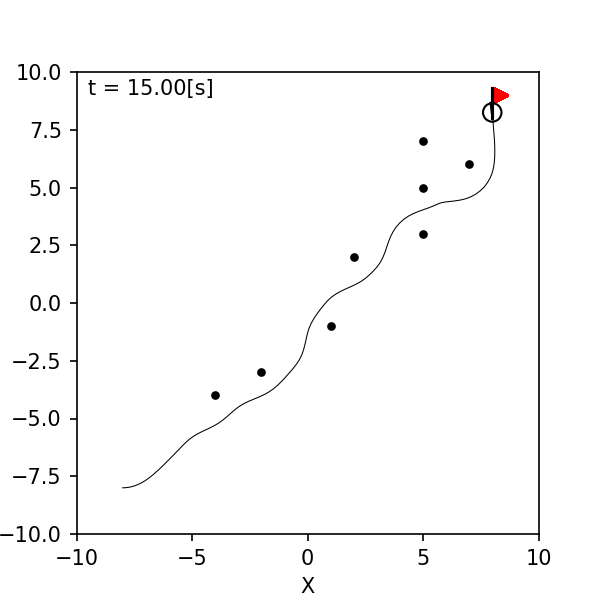

In [9]:
if __name__ == "__main__":
    time_span = 15
    time_interval = 0.1
    
    start_pose = np.array([-8, -8, 0]).T
    goal = [8, 8]
    map_size = [10, 10]
    
    world = World(time_span, time_interval, debug=False, map_size=map_size)

    m = Map(goal=goal, map_size=map_size)
    '''
    m.append_obstacle(Obstacle(6, 2))
    m.append_obstacle(Obstacle(6, 3))
    m.append_obstacle(Obstacle(6, 4))
    m.append_obstacle(Obstacle(6, 5))
    m.append_obstacle(Obstacle(6, 6))
    m.append_obstacle(Obstacle(6, 7))
    m.append_obstacle(Obstacle(3, 0))
    m.append_obstacle(Obstacle(0, -1))
    m.append_obstacle(Obstacle(-2, -4))
    m.append_obstacle(Obstacle(-4, -3.5))
    '''
    
    m.append_obstacle(Obstacle(-4, -4))
    m.append_obstacle(Obstacle(-2, -3))
    m.append_obstacle(Obstacle(1, -1))
    m.append_obstacle(Obstacle(2, 2))
    m.append_obstacle(Obstacle(5, 3))
    m.append_obstacle(Obstacle(5, 5))
    m.append_obstacle(Obstacle(5, 7))
    m.append_obstacle(Obstacle(7, 6))
    world.append(m)
    
    dwa_agent = DwaAgent(
        m,
        velocity=np.array([1.0, 20/180*np.pi]).T,
        nu_limit=[0, 2.5], omega_limit=[-80/180*math.pi, 80/180*math.pi],
        kH=1, kN=100, kO=10
    )
    robot = IdealRobot(start_pose, dwa_agent, IdealCamera(m))
    world.append(robot)
    
    world.draw()
    
    #world.ani.save('anm.gif', writer='pillow', fps=10)    #アニメーション保存